# Title : Analyzing Air Quality Index (AQI) Trends in a City

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings 

In [3]:
# Supressing update warnings
warnings.filterwarnings('ignore') 

In [17]:
data = pd.read_csv("./datasets/data.csv", encoding="cp1252") 
data


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435737,SAMP,24-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,22.0,50.0,143.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-24
435738,SAMP,29-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,20.0,46.0,171.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-29
435739,NaN,NaN,andaman-and-nicobar-islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435740,NaN,NaN,Lakshadweep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [15]:
data['type'].unique()


array(['RRO', 'I', 'S', 'RO', 'R', 'RIRUO'], dtype=object)

In [6]:
# Cleaning up name changes
data.state = data.state.replace({'Uttaranchal':'Uttarakhand'}) 
data.state[data.location == "Jamshedpur"] = data.state[data.location == 'Jamshedpur'].replace({"Bihar":"Jharkhand"})

In [7]:
# Changing types to uniform format
types = {
    "Residential": "R", 
    "Residential and others": "RO",
    "Residential, Rural and other Areas": "RRO", 
    "Industrial Area": "I",
    "Industrial Areas": "I", 
    "Industrial": "I", 
    "Sensitive Area": "S", 
    "Sensitive Areas": "S", 
    "Sensitive": "S", 
    np.nan: "RRO"
}

data.type = data.type.replace(types) 
data.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,I,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,RRO,6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,I,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [8]:
# defining columns of importance, which shall be used reguarly 
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']

In [21]:
# Separate categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols = data.select_dtypes(include=['number']).columns

# Fill missing values in categorical columns with the mode
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Fill missing values in numerical columns with the mean
for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace=True)


In [22]:
# checking to see if the dataset has any null values left over and the format 
print(data.isnull().sum())
# data.tail()

stn_code                       0
sampling_date                  0
state                          0
location                       0
agency                         0
type                           0
so2                            0
no2                            0
rspm                           0
spm                            0
location_monitoring_station    0
pm2_5                          0
date                           0
dtype: int64


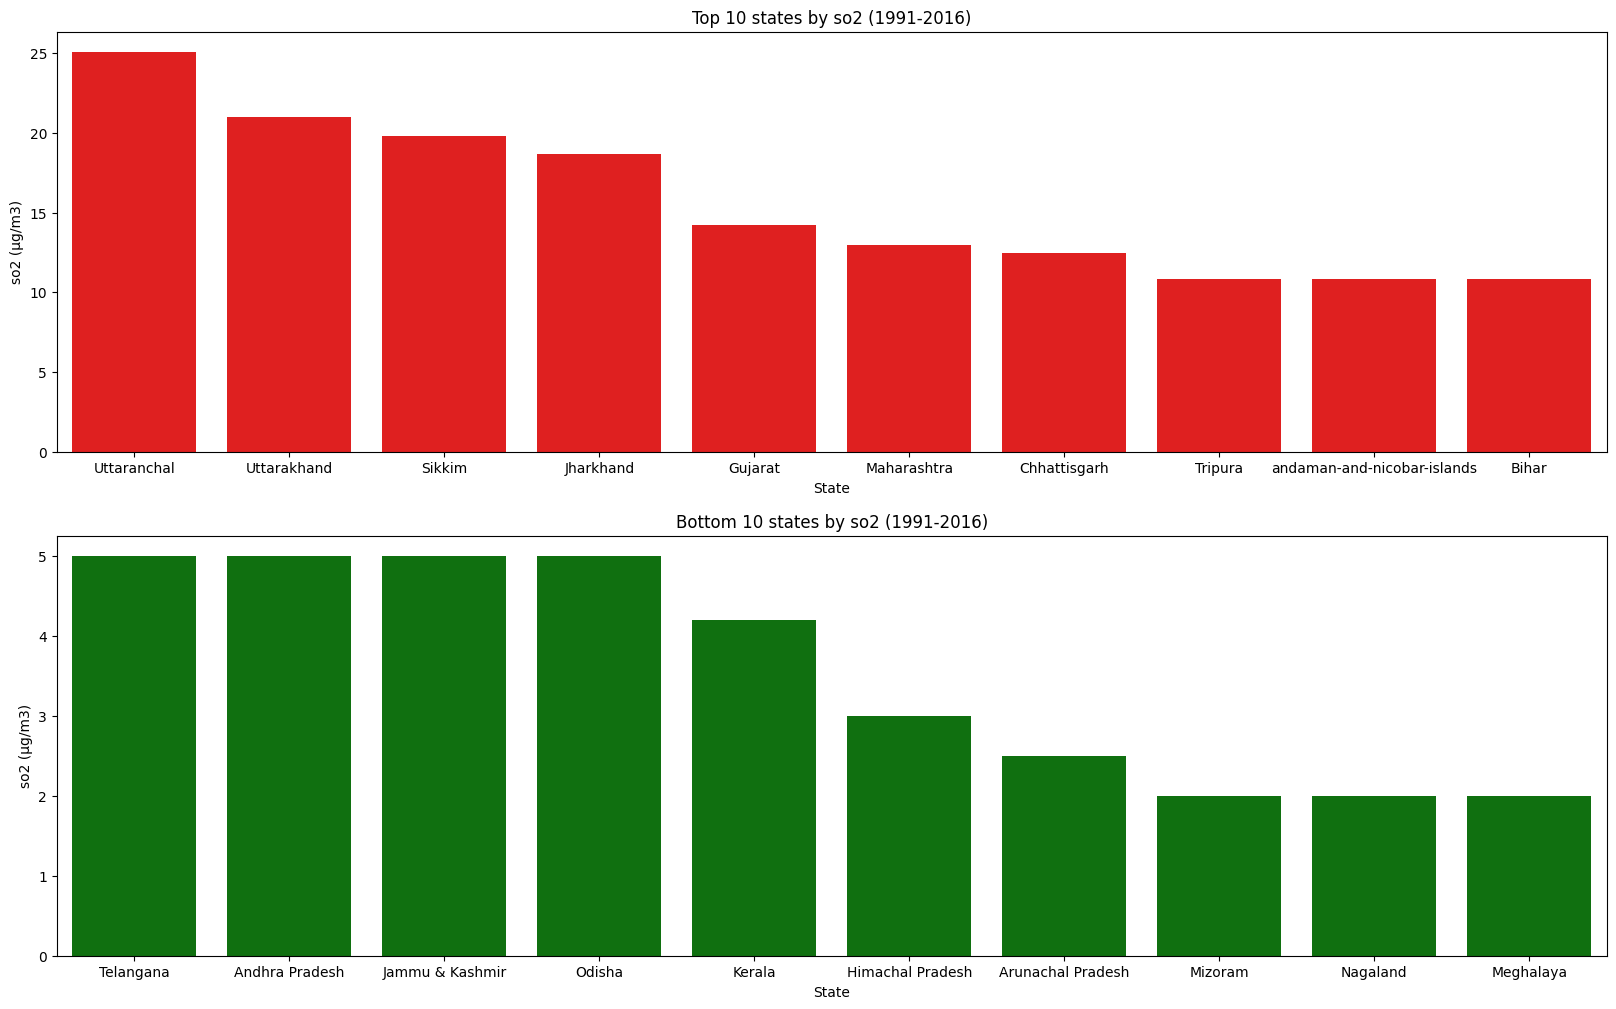

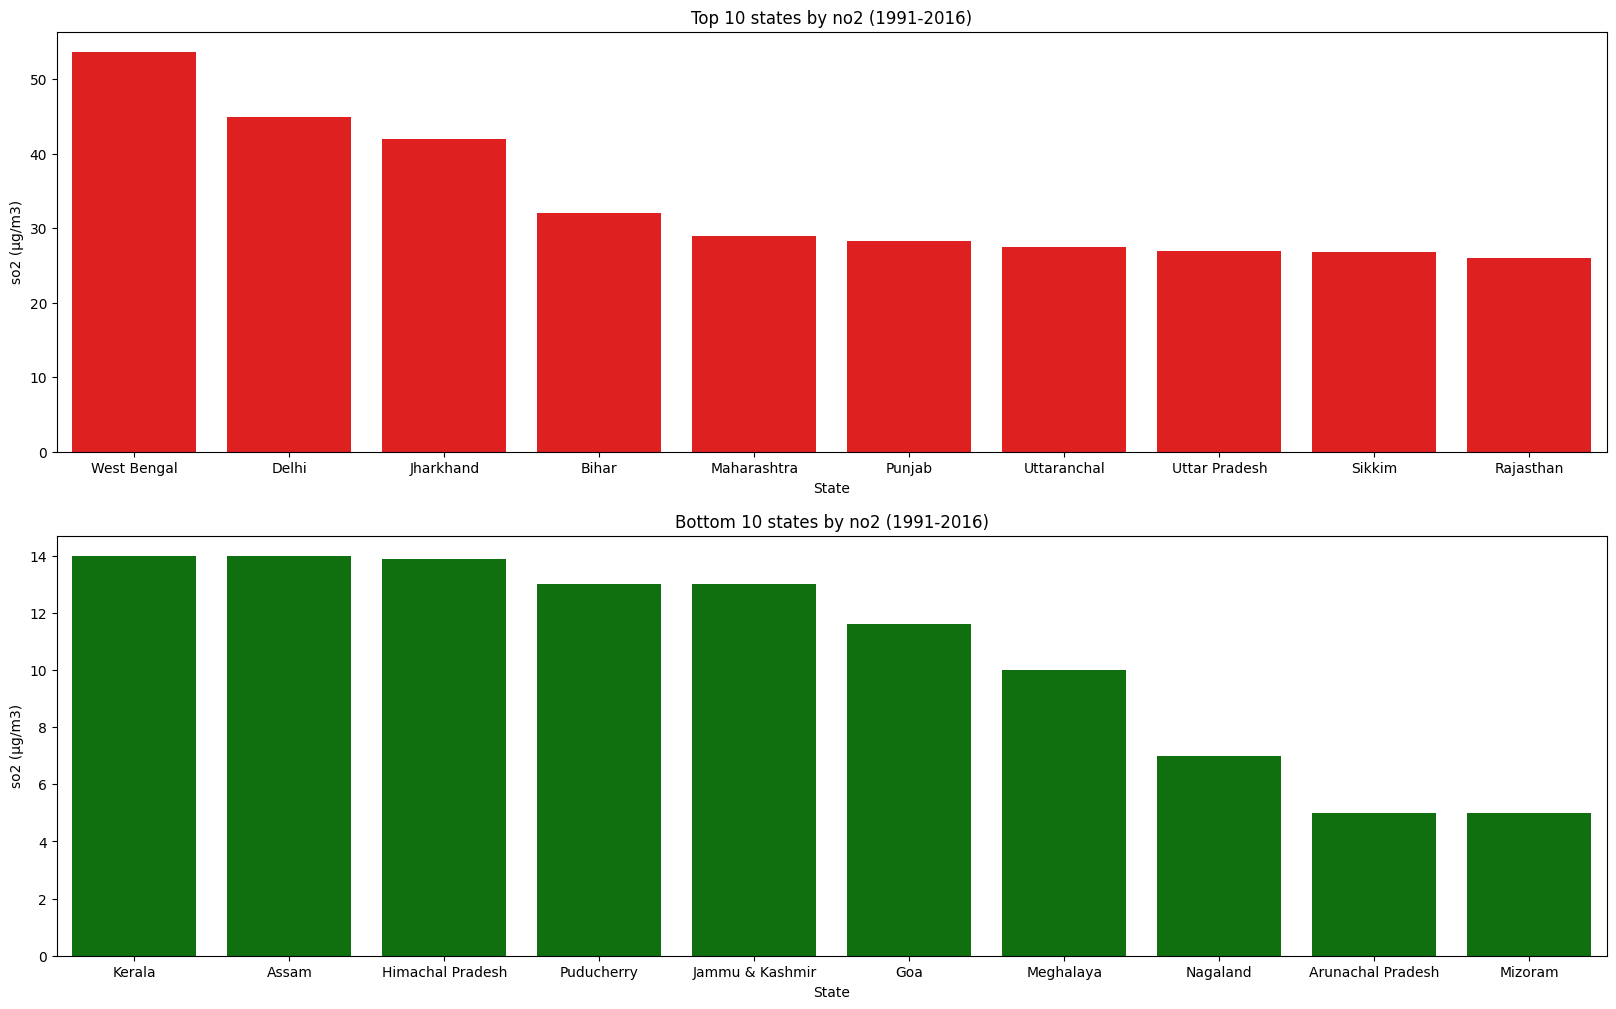

In [27]:
# Plotting highest and lowest ranking states
# defining a function to find and plot the top 10 and bottom 10 states for a given indicator (defaults to SO2) 
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    ind = data[[indicator, 'state']].groupby('state', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='state', y=indicator, data=ind[:10], ax=ax[0], color='red') 
    top10.set_title("Top 10 states by {} (1991-2016)".format(indicator)) 
    top10.set_ylabel("so2 (µg/m3)")
    top10.set_xlabel("State")

    
    bottom10 = sns.barplot(x='state', y=indicator, data=ind[-10:], ax=ax[1], color='green') 
    bottom10.set_title("Bottom 10 states by {} (1991-2016)".format(indicator)) 
    bottom10.set_ylabel("so2 (µg/m3)")
    bottom10.set_xlabel("State") 

top_and_bottom_10_states("so2") 
top_and_bottom_10_states("no2")

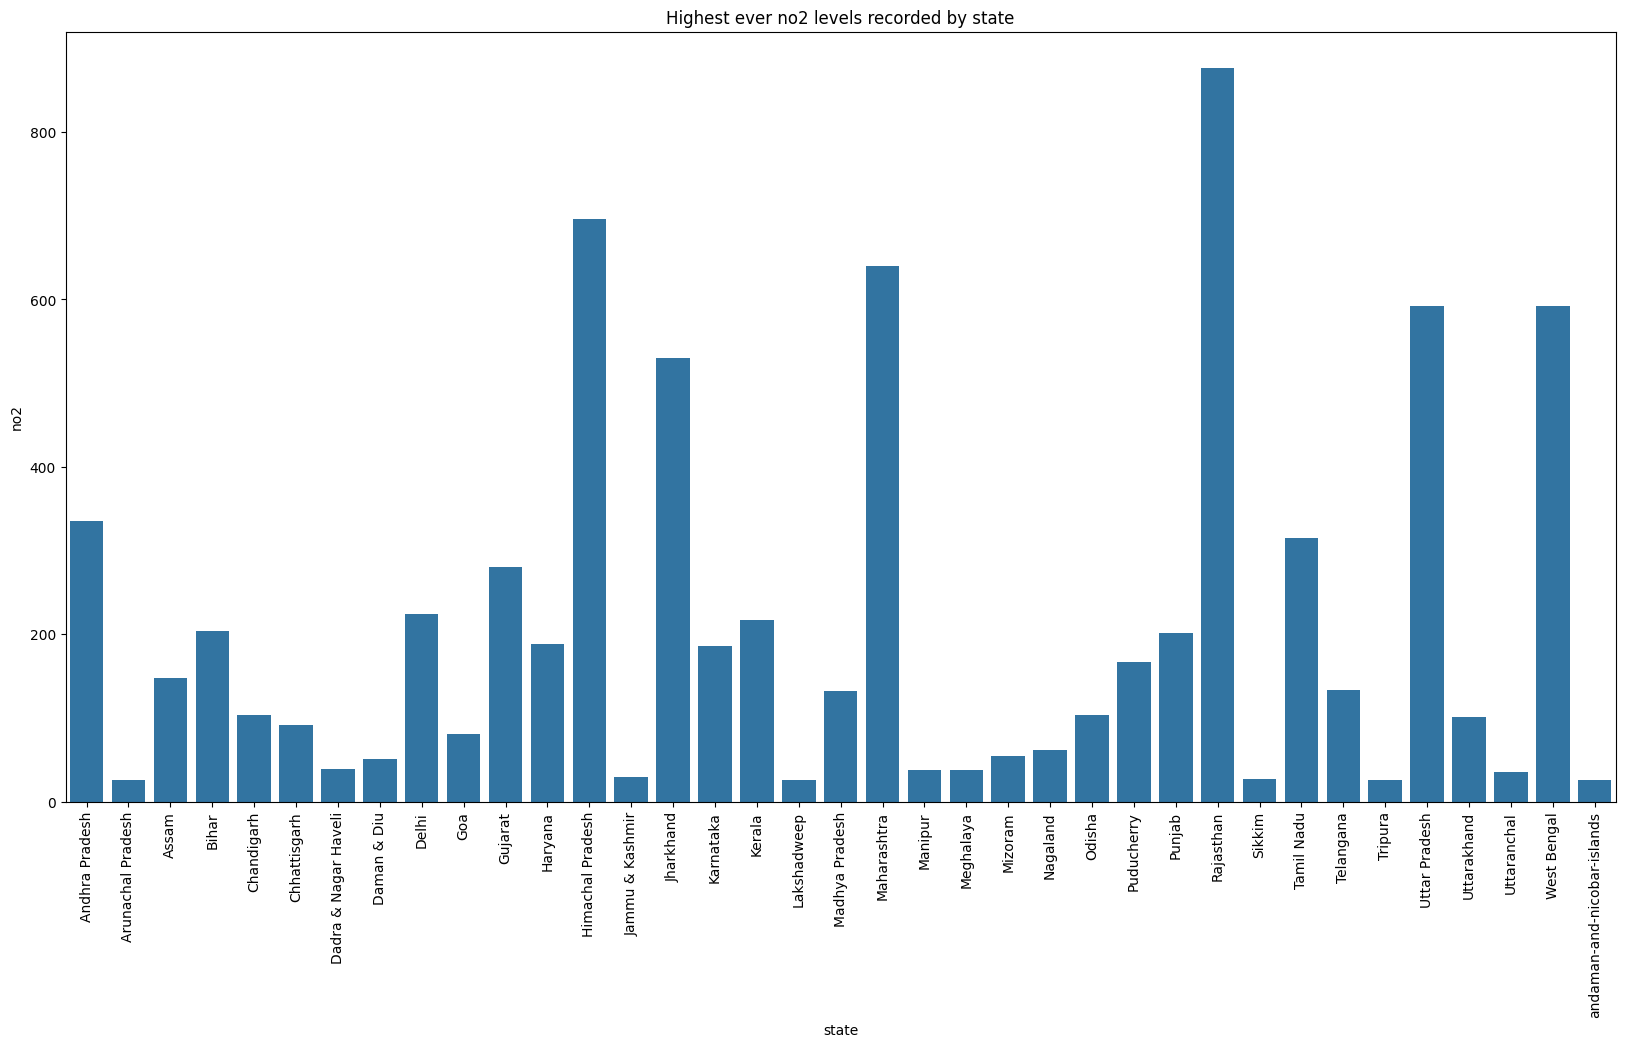

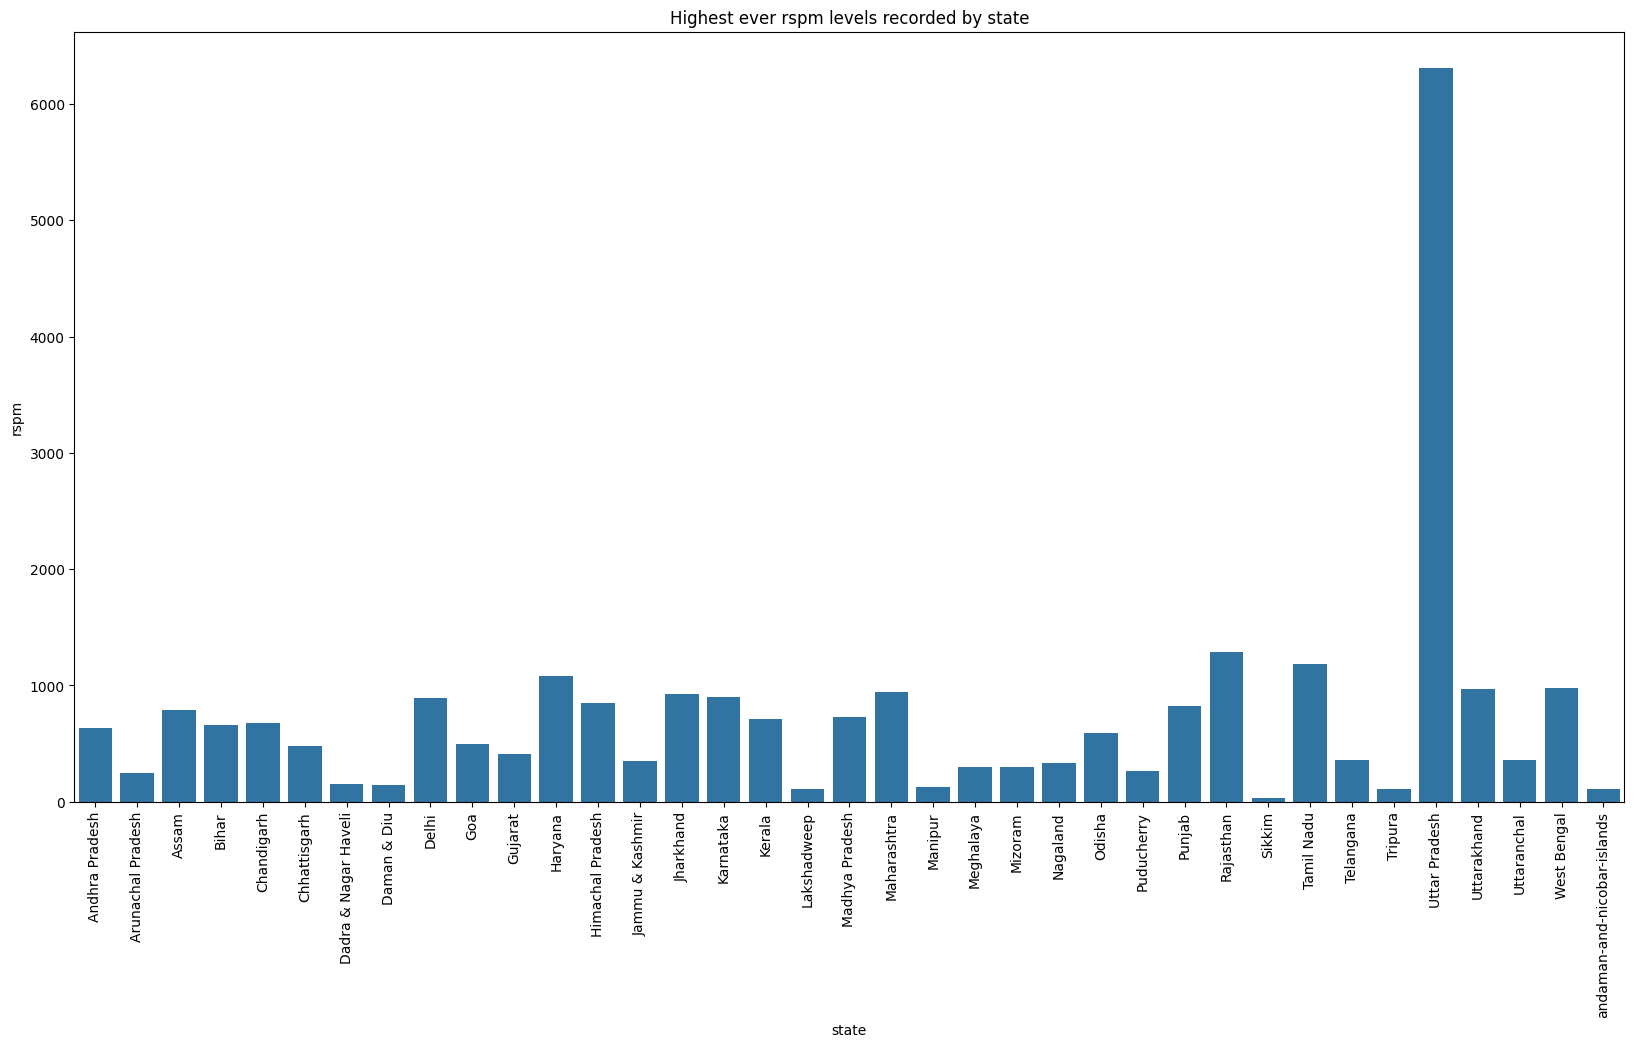

In [30]:
# Plotting the highest ever recorded levels
# defining a function to find the highest ever recorded levels for a given indicator (defaults to SO2) by state 
# sidenote: mostly outliers
def highest_levels_recorded(indicator="so2"): 
    plt.figure(figsize=(20,10))
    ind = data[[indicator, 'location', 'state', 'date']].groupby('state', as_index=False).max() 
    highest = sns.barplot(x='state', y=indicator, data=ind)
    highest.set_title("Highest ever {} levels recorded by state".format(indicator))
    plt.xticks(rotation=90) 
    
highest_levels_recorded("no2") 
highest_levels_recorded("rspm")

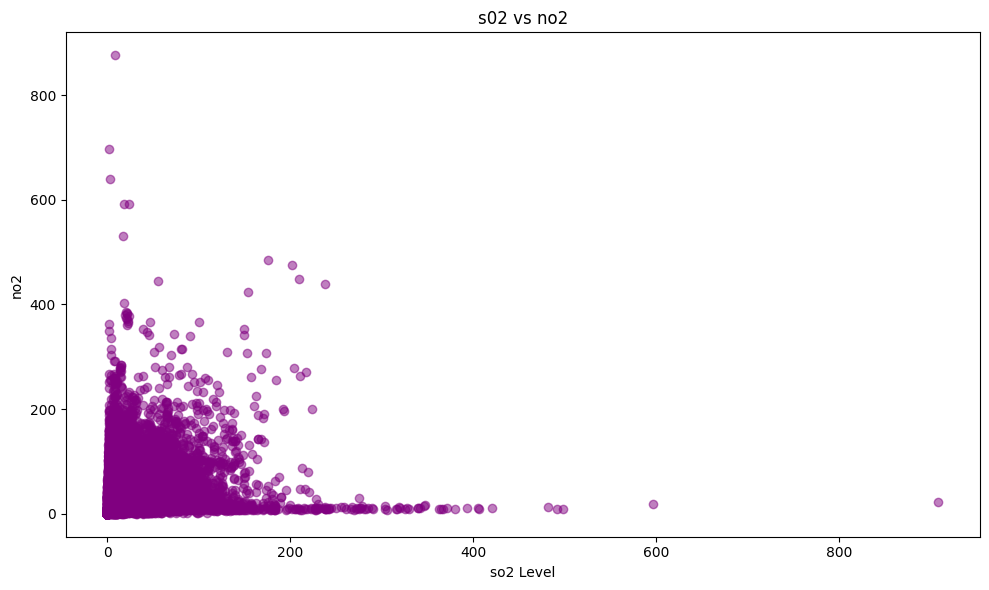

In [44]:
# Scatter plot for AQI vs PM2.5
plt.figure(figsize=(10, 6))
plt.scatter(data['so2'], data['no2'], alpha=0.5, color='purple')
plt.xlabel('so2 Level')
plt.ylabel('no2')
plt.title('s02 vs no2')
plt.tight_layout()
plt.show()

# # Bubble chart (Optional) - if you want to scale with another variable (e.g., CO)
# plt.figure(figsize=(10, 6))
# plt.scatter(data['so2'], data['no2'], s=data['CO']*10, alpha=0.5, color='cyan')
# plt.xlabel('so2 Level')
# plt.ylabel('no2')
# plt.title('s02 vs no2(Bubble Chart)')
# plt.tight_layout()
# plt.show()


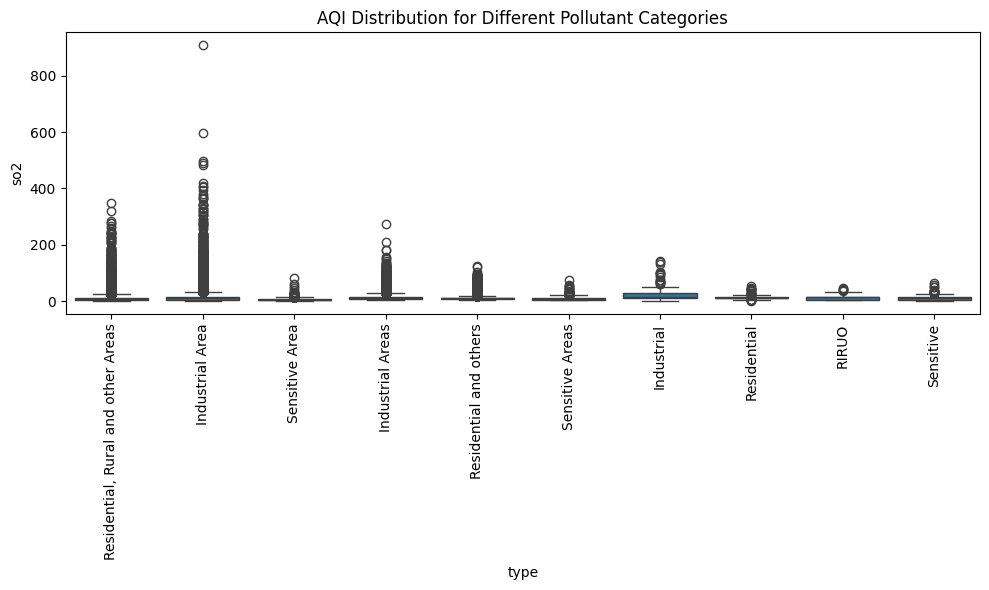

In [53]:
import seaborn as sns

# Box plot for AQI distribution based on pollutant categories (e.g., PM2.5, PM10, CO)
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='so2', data=data)
plt.title('AQI Distribution for Different Pollutant Categories')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
